### Q1: First implementation of the hash algorithm

In order to detect plagiarism, we need to slice the input texts into a specific length of substrings, store them and compare them. Considering these steps, it will be optimal to find a data structure which takes average O(1) to insert and search these values. Firstly, we can consider storing the substrings into an array. However, since there is no way to know which specific substring is stored in which specific index, we will need to iterate through the whole array until we find the matching values. This will result in average time complexity O(n) for search, leading to O(nm) to go over each substring in the input texts. We can also consider Trie, which traverse a substring and add it to the existing structure. It might be effective especially considering the space complexity, but it is likely to add more complexity regarding time because we need to use recursion to insert and search from the tree. And since we are looking up entire words not by their prefix to detect plagiarism, hash table would be more advantageous to build plagiarism detector.

A hash table is a datastructure which stores data in an associative manner. In a hash table, data is stored in an array format and each data value has its own index value. We utilize hash function to compute the index so that we can store the value in a specific location and ultimately access it quickly. 

In average, hash table takes O(1) to search, insert, and delete the values because it is a rare case that the values are stored to the same key. But sometimes when there are too many values hashed into the same key, looking inside the key may take O(n) time. In order to prevent this collision, it is necessary to choose a good hash function, implement different methods such as probing or chaining, and control the load balance.

In the first version of the algorithm, I implemented rolling hashing to improve the time complexity. If we use normal hashing without rolling, it will result in the time complexity of average O(nm) because we will need to take each substring in text2, calculate the hash value, and compare it with the substrings in text1. However, by setting a window and reusing already calculated values from the previous window, average time complexity could be improved to O(n+m). I also utilized double hashing to prevent collisions because it is known as the most effective method among probing methods. Chaining was also in consideration because is is an effective solution when the load factor gets bigger than roughly 0.8. In that case, collisions can happen more frequently and it could be a good decision to store a the values that have the same key in the same slot. However, when there is enough space, it is more effective to use probing since only single value is stored in a slot. This will make inserting and searching more effectively. In order to ensure that the load factor is below 0.6 for every input, I implemented a method that adjusts the table size depending on the length of the input strings.

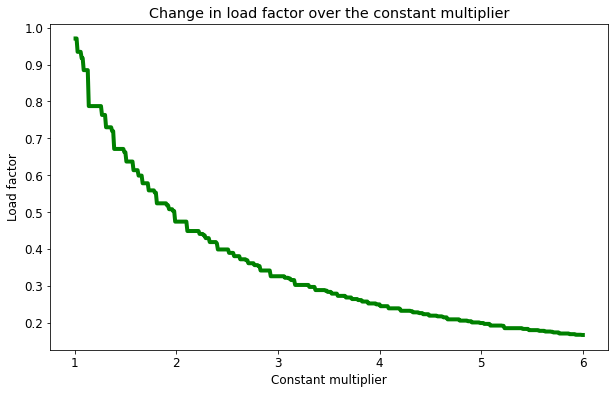

In [127]:
import time
import random
import string
import matplotlib.pyplot as plt

def table_size(text, constant):
    text_length = len(text) # Obtain the length of input string
    table_size = int(text_length * constant) # multiple by some factor between 1-2 and floor it
    prime = next_prime(table_size) # get the next prime of this length
    
    return prime

def load_factor(text, table_size):
    # Computes the load factor, which is the length of input string devided by the table size
    return len(text)/table_size
    
def next_prime(n):
    """
    Gets the next prime with a given integer
    """
    notprime = [num for num in range (n+1, n+200)]
    isprime = []
        
    for num in notprime:
        val_is_prime = True

        for x in range(2, num-1):
            if num % x == 0:
                val_is_prime = False
                break
                
        if val_is_prime:
            isprime.append(num)
            break
            
    return min(isprime)

def random_string(length):
    """
    Generates a random string in lowercase of a specified length
    """
    letters = string.ascii_lowercase
    result = ''.join(random.choice(letters) for i in range(length))
    return result 


load_factors = []
constants = [1 + i/100 for i in range(1, 501)]

for c in constants:
    random_str = random_string(100)
    size = table_size(random_str, c)
    load = load_factor(random_str, size)
    load_factors.append(load)
    
plt.plot(constants, load_factors, color='green')
plt.rcParams.update({'font.size': 12})
plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams['lines.linewidth'] = 4
plt.title("Change in load factor over the constant multiplier")
plt.xlabel("Constant multiplier")
plt.ylabel("Load factor")
plt.show()

In order to adjust the table size, I devised a test to figure out which constant should be multiplied to the length of the input text to ensure that the load factor is around 0.6. There are a few criteria that the table size needs to satisfy. It should be the same or bigger than the length of the input text because when the window is 1, every character in the input is going to occupy a slot in the table. The size should also be same with the modulo; if the size is bigger than the modulo, there is a huge chance that the last slots of the table will not be filled, and if the size is smaller than the modulo, the index (mod of modulo) might be out of range of the size of the hash table. Since modulo should be a prime number to reduce collisions, the hash table size should also be a prime number, which is equal to modulo. 

The code cell above shows the relationship between the load factor and the constant as constant varies from 1 to 2. We can identify that the load factor is around 0.6 when the constant factor is around 1.7. It makes sure that the space in the table is occupied more than 50% but not too much to avoid collision. If the load factor is more than 0.8, using chaining might be more useful. So in this implementation, I keep the load factor as 0.6 while utilizing probing.

In [306]:
## 1st Version


class HashTable:
    
    alphabet = 26
    normalize = ord('a') - 1 
    
    def __init__(self, text1, text2, size):

        self.table_size = self.get_table_size(text1)
        self.modulo = self.table_size
        self.hash_table = [None for _ in range(self.table_size)]
        
        self.text1 = text1
        self.text2 = text2
        self.size = size
        self.multiplier = self.alphabet ** (size - 1)
        
        # Initialize the first node in the hash table without probing
        # because the hash table will be empty
        hash_value = 0
        power_of_alphabet = size-1 
        for char in text1[:size]:
            hash_value = ((hash_value + (ord(char) - self.normalize) * (self.alphabet)**power_of_alphabet) % self.modulo)
            power_of_alphabet -= 1
        self.hash = hash_value
        index = hash_value % self.table_size
        self.hash_table[index] = HashTableNode(hash_value, 0, text1[:size])
    
        
        # Set the window so that we can start from removing the first value when rolling
        self.window_start = 0
        self.window_end = self.size 
        
        
    def get_table_size(self, text1):
        """
        Determines the hash table size depending on the length of the input text
        
        Output: 
        - The size of the hash table, which is a prime number
        """

        length = len(text1) # get length of input string x
        table_size = int(length * 1.7) # multiply by 1.7
        prime = self.get_next_prime(table_size) # get the next prime of this length
    
        return prime
    
    
    def get_next_prime(self, n):
        """
        Gets the next prime with a given integer
        
        Output: 
        - The next prime number
        """
        notprime = [num for num in range (n+1, n+200)]
        isprime = []
        
        for num in notprime:
            val_is_prime = True

            for x in range(2, num-1):
                if num % x == 0:
                    val_is_prime = False
                    break
                
            if val_is_prime:
                isprime.append(num)
                break
            
        return min(isprime)
        
    
    def build_table(self):
        """
        Build hash table using rolling hashing method
        """
        while self.window_end < len(self.text1):
            removal = self.hash - ((ord(self.text1[self.window_start]) - self.normalize) * self.multiplier)
            multi = removal * self.alphabet
            addition = multi + (ord(self.text1[self.window_end]) - self.normalize)
            final = addition % self.modulo
            self.hash = final
            
            self.open_addressing_insert(final, self.window_start+1, self.text1[self.window_start+1:self.window_end+1])

            self.window_start += 1
            self.window_end += 1
                        
        
    def compute_hash(self, text):
        """
        Compute hash values of the input text
    
        Output: 
        - The hash value of the input text
        """
        hash_value = 0
        size = self.size
        power_of_alphabet = size-1
        for char in text:
            hash_value = ((hash_value + (ord(char) - self.normalize) * (self.alphabet)**power_of_alphabet) % self.modulo)
            power_of_alphabet -= 1
        return hash_value
    
    
    def hash_function_1(self, hash_value):
        """
        We use this method to figure out the index of a specific hash_value in the hash_table
        """
        return hash_value % self.table_size

    
    def hash_function_2(self, hash_value):
        PRIME = 7 # we can also choose any prime < table size
        return PRIME - self.size % (PRIME)
    
    
    def probing_sequence(self, hash_value, i):
        """
        Adopt double hashing method for probing when there is a collision
        
        Output: The index of the next slot that the value should be stored
        """
        return (self.hash_function_1(hash_value) + i * self.hash_function_2(hash_value)) % self.table_size
    
    
    def open_addressing_insert(self, hash_value, start_index, substring):
        """
        Insert the hash value, start index, substring in the hash table
        Use probing if there is already a value stored in the slot
        
        """
        i = 0
        while i < self.table_size:
            j = self.probing_sequence(hash_value, i)
            # if we find an empty slot
            if self.hash_table[j] is None:
                # we insert the key and values into the hash table
                self.hash_table[j] = HashTableNode(hash_value, start_index, substring)
                return
            # else we increase i and continue probing
            else:
                i += 1
        raise Exception("All slots in hash table is filled...")

        
    def open_addressing_search(self, hash_value, substring):
        """
        Check if there is a substring matching with the input substring in the hash table 
        Use probing to find another matching substring even if the algorithm found one
    
        Output: 
        - A list of lists containing the start index and the substring of the matching values
        """
        i = 0
        lst = []
        while i < self.table_size:
            j = self.probing_sequence(hash_value, i)
            if self.hash_table[j] is None:
                pass
            elif self.hash_table[j].key == hash_value and self.hash_table[j].substring == substring:
                lst.append([self.hash_table[j].start_index, self.hash_table[j].substring])
            i += 1
        if len(lst) != 0:
            return lst
        else:
            return False
    
    
    
    def make_comparison(self):
        """
        Finds all common length-size substrings of text1 and text2 
        by using rolling hashing method
    
        Output: 
        - A list of tuples (i,j) where text1[i:i+k] = text2[j:j+k]
        """
        output = []
        for i in range(len(self.text2)-self.size+1):
            window = self.text2[i:i+self.size]
            hash_value = self.compute_hash(window)
            result = self.open_addressing_search(hash_value, window)
            if result is not False:
                for lst in result:
                    output.append((lst[0], i))
        return output
    


class HashTableNode:
   
    def __init__(self, hash_value, start_index, substring):
        self.key = hash_value
        self.start_index = start_index
        self.substring = substring
        
        
    # Define 'representation' method that helps users to understand the instance of this class
    def __repr__(self):
        return f'{self.key}, {self.start_index}, {self.substring}'


In [307]:
# Test1 - repeating sequence
sequence = HashTable('limlimlim', 'limhayounglimhayounglimhayounglimhayoung', 3)
sequence.build_table()
assert sequence.make_comparison() == [(0, 0), (3, 0), (6, 0), (0, 10), (3, 10), (6, 10), (0, 20), (3, 20), (6, 20), (0, 30), (3, 30), (6, 30)]

# Test2 - repeating characters
character = HashTable('hhhhhhhaaaaaaadddddd', 'hhaaddff', 2)
character.build_table()
assert character.make_comparison() == [(0, 0), (1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 1), (7, 2), (8, 2), (9, 2), (10, 2), (11, 2), (12, 2), (13, 3), (14, 4), (15, 4), (16, 4), (17, 4), (18, 4)]

# Test3 - real sentences
sentence1 = "When your focus is to improve employee performance, it’s essential to encourage ongoing dialogue between managers and their direct reports.".replace("!", "").replace("?", "").replace(".", "").replace(",", "").replace(";", "").replace(" ", "").lower()
sentence2 = "When your focus is to improve employee performance, ongoing dialogue between managers and their direct reports is essential.".replace("!", "").replace("?", "").replace(".", "").replace(",", "").replace(";", "").replace(" ", "").lower()
sentence = HashTable(sentence1, sentence2, 40)
sentence.build_table()
assert sentence.make_comparison() == [(0, 0), (1, 1), (2, 2), (3, 3), (66, 42), (67, 43), (68, 44), (69, 45), (70, 46), (71, 47), (72, 48), (73, 49), (74, 50), (75, 51), (76, 52), (77, 53), (78, 54)]



### Q2: Second implementation of the hash algorithm

In the second version, I removed the feature of rolling hashing and implemented brute force approach, going over each substring and caclculating hash values. I applied two different hash functions called djb2 and sdbm. (I also briefly looked into a function called 'loselose' but it generated pretty similar hash values for similar texts, making the slots in the table easily concentrated in certain index.) These functions could parimarily be assessed by whether they evenly distribute the indices across the entire table. I generated a plot 3 code cells below to figure out which function would be better regarding this criteria. Since sdbm demonstrated better performance, I decided to use it whem comparing the second version with the first version in Q3.

In [308]:
## 2nd Version

class HashTable2:
    
    alphabet = 26
    normalize = ord('a') - 1 
    
    def __init__(self, text1, text2, size):

        
        self.table_size = self.get_table_size(text1)
        self.hash_table = [None for _ in range(self.table_size)]
        self.modulo = self.table_size
        
        self.text1 = text1
        self.text2 = text2
        self.size = size
        self.multiplier = self.alphabet ** (size - 1)
        

    def get_table_size(self, text1):
        """
        Determines the hash table size depending on the length of the input text
        
        Output: 
        - The size of the hash table, which is a prime number
        """


        length = len(text1) # get length of input string x
        table_size = int(length * 1.7) # multiply by 1.7
        prime = self.get_next_prime(table_size) # get the next prime of this length
    
        return prime
    
    
    def get_next_prime(self, n):
        """
        Gets the next prime with a given integer
        
        Output: 
        - The next prime number
        """
        notprime = [num for num in range (n+1, n+200)]
        isprime = []
        
        for num in notprime:
            val_is_prime = True

            for x in range(2, num-1):
                if num % x == 0:
                    val_is_prime = False
                    break
                
            if val_is_prime:
                isprime.append(num)
                break
            
        return min(isprime)        
        
        
    def djb2(self, text):
        """
        Converts a key into an index using the djb2 hash function
        """
        hash = 5381
        for x in text:
            hash = ((hash<<5)+hash)+ord(x) # h*33+ord(c)
        return hash&0xFFFFFFFF % self.modulo
            
        
    def sdbm(self, text):
        """
        Converts a key into an index using the sdbm hash function
        """
        hash_val = 0
        for char in text:
            hash_val = ord(char) + (hash_val << 6) + (hash_val << 16) - hash_val
        return hash_val % self.modulo


    def hash_function_1(self, hash_value):
        """
        We use this method to figure out the index of a specific hash_value in the hash_table
        """
        return hash_value % self.table_size

    
    def hash_function_2(self, hash_value):
        PRIME = 7 # we can also choose any prime < table size
        return PRIME - self.size % (PRIME)
    
    
    def probing_sequence(self, hash_value, i):
        """
        Adopt double hashing method for probing when there is a collision
        
        Output: The index of the next slot that the value should be stored
        """
        return (self.hash_function_1(hash_value) + i * self.hash_function_2(hash_value)) % self.table_size        
        
            
    def open_addressing_insert(self, hash_value, start_index, substring):
        """
        Insert the hash value, start index, substring in the hash table
        Use probing if there is already a value stored in the slot
        
        """
        i = 0
        while i < self.table_size:
            j = self.probing_sequence(hash_value, i)
            # if we find an empty slot
            if self.hash_table[j] is None:
                # we insert the key and values into the hash table
                self.hash_table[j] = HashTableNode(hash_value, start_index, substring)
                return
            # else we increase i and continue probing
            else:
                i += 1
        raise Exception("All slots in hash table is filled...")
        
            
            
    def open_addressing_search(self, hash_value, substring):
        """
        Check if there is a substring matching with the input substring in the hash table 
        Use probing to find another matching substring even if the algorithm found one
    
        Output: 
        - A list of lists containing the start index and the substring of the matching values
        """
        i = 0
        lst = []
        while i < self.table_size:
            j = self.probing_sequence(hash_value, i)
            if self.hash_table[j] is None:
                pass
            elif self.hash_table[j].key == hash_value and self.hash_table[j].substring == substring:
                lst.append([self.hash_table[j].start_index, self.hash_table[j].substring])
            i += 1
        if len(lst) != 0:
            return lst
        else:
            return False
                
        
    def build_table_djb2(self):
        """
        Build hash table using djb2
        """
        for i in range(len(self.text1)-self.size+1):
            window = self.text1[i:i+self.size]
            hash_value = self.djb2(window)
            self.open_addressing_insert(hash_value, i, window)
            
            
    def build_table_sdbm(self):
        """
        Build hash table using sdbm
        """
        for i in range(len(self.text1)-self.size+1):
            window = self.text1[i:i+self.size]
            hash_value = self.sdbm(window)
            self.open_addressing_insert(hash_value, i, window)
                
            
                        
    def make_comparison_djb2(self):
        """
        Finds all common length-k substrings of text1 and text2 
        using djb2 function for hash values.
    
        Output: 
        - A list of tuples (i,j) where x[i:i+k]= y[j:j+k]
        """
        output = []
        for i in range(len(self.text2)-self.size+1):
            window = self.text2[i:i+self.size]
            hash_value = self.djb2(window)
            result = self.open_addressing_search(hash_value, window)
            if result is not False:
                for lst in result:
                    output.append((lst[0], i))
        return output
    
    
    def make_comparison_sdbm(self):
        """
        Finds all common length-k substrings of text1 and text2
        using sdbm function for hash values.
    
        Output: 
        - A list of tuples (i,j) where x[i:i+k]= y[j:j+k]
        """
        output = []
        for i in range(len(self.text2)-self.size+1):
            window = self.text2[i:i+self.size]
            hash_value = self.sdbm(window)
            result = self.open_addressing_search(hash_value, window)
            if result is not False:
                for lst in result:
                    output.append((lst[0], i))
        return output
        
        

class HashTableNode2:
   
    def __init__(self, hash_value, start_index, substring):
        self.key = hash_value
        self.start_index = start_index
        self.substring = substring
        
        
    # Define 'representation' method that helps users to understand the instance of this class
    def __repr__(self):
        return f'{self.key}, {self.start_index}, {self.substring}'

In [309]:
# Test1 - repeating sequence
sequence = HashTable2('daybydaymonthbymonth', 'daybymonth', 5)
sequence.build_table_djb2()
assert sequence.make_comparison_djb2() == [(0, 0), (13, 3), (7, 4), (14, 4), (8, 5), (15, 5)]
sequence.build_table_sdbm()
assert sequence.make_comparison_sdbm() == [(0, 0), (13, 3), (7, 4), (14, 4), (8, 5), (15, 5)]


# # Test2 - repeating characters
character = HashTable2('ddddooonnnere', 'dddddddddddd', 4)
character.build_table_djb2()
assert character.make_comparison_djb2() == [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8)]
character.build_table_sdbm()
assert character.make_comparison_sdbm() == [(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8)]

# Test3 - real sentences
sentence1 = "My mama always said life was like a box of chocolates.".replace("!", "").replace("?", "").replace(".", "").replace(",", "").replace(";", "").replace(" ", "").lower()
sentence2 = "My mom always said life is like a box full of chocolates.".replace("!", "").replace("?", "").replace(".", "").replace(",", "").replace(";", "").replace(" ", "").lower()
sentence = HashTable2(sentence1, sentence2, 6)
sentence.build_table_djb2()
assert sentence.make_comparison_djb2() == [(6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (22, 20), (23, 21), (24, 22), (25, 23), (31, 33), (32, 34), (33, 35), (34, 36), (35, 37), (36, 38), (37, 39)]
sentence.build_table_sdbm()
assert sentence.make_comparison_sdbm() == [(6, 5), (7, 6), (8, 7), (9, 8), (10, 9), (11, 10), (12, 11), (13, 12), (14, 13), (22, 20), (23, 21), (24, 22), (25, 23), (31, 33), (32, 34), (33, 35), (34, 36), (35, 37), (36, 38), (37, 39)]


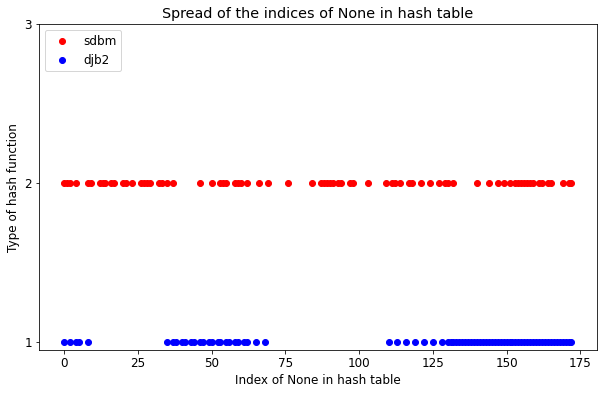

In [310]:
def random_string(length):
    """
    Generates a random string in lowercase of a specified length
    """
    letters = string.ascii_lowercase
    result = ''.join(random.choice(letters) for i in range(length))
    return result 


text = get_random_string(100)

table = HashTable2(text, '', 4)
table.build_table_djb2()
lst = table.hash_table
djb2 = [i for i, x in enumerate(lst) if x == None]
djb2_line = [1 for i in range(len(djb2))]


table = HashTable2(text, '', 4)
table.build_table_sdbm()
lst = table.hash_table
sdbm = [i for i, x in enumerate(lst) if x == None]
sdbm_line = [2 for i in range(len(djb2))]


plt.scatter(sdbm, sdbm_line, color="red", label="sdbm")
plt.scatter(djb2, djb2_line, color="blue", label="djb2")
plt.title("Spread of the indices of None in hash table")
plt.yticks([1,2,3])
plt.xlabel("Index of None in hash table")
plt.ylabel("Type of hash function")
plt.legend(loc='upper left')
plt.show()

### Q3: Real-life implementation for plagiarism

There is a "five word rule" in the world of academia, indicating that if more than five consecutive words are identical to someone else's writing, it should be considered as plagiarism. Since the average English word length is 5, I will set the window size as 25 and run the algorithm to detect plagiarism. 

However, applying this algorithm will be difficult in real life for several reasons. The biggest pitfall is that it can only detect verbatim plagiarism. The sequence of words should be exactly same as the original text to be detected as a plagiarism. In real life, there are numerous plagiarism cases that don't completely copy the original text. Many of them try to paraphrase or summarize the original text without giving enough credit to the author. Also, even if I set the window size as 25, there should be many cases that don't necessarily involve 5 consecutive words. Since the algorithm could only operate with a fixed size of window, it will be quite troublesome to run the detector over and over again with different size.

### Q4: Complexity analysis

○ First version implementation of rolling hashing

In this case, inserting process is going to be O(n). The first thing we do is initilizing the first node according to the window size and continue calculating hash values and index of the substrings as the window moves. This whole process is going to take O(n). However, if the table size is too small and it requires considerable amount of probing, the time complexity can increase exponentially to O(n^2). Since I made sure that the table will have enough space depending on each input by multiplying 1.7, the algorithm is expected to go through only 0-2 probes, which ensures the time complexity of O(n). Similarly, the searching process is also going to be O(n). However, the number of probes is likely to be bigger in searching than in inserting because as identified in test cases, there could be repeating sequences in the text1. It signifies that the algorithm should keep probing even if it finds the matching hash value and a matching string, because there could be more of them stored in other slots. However, if we implement an enough table size and a decent probing method, we can still ensure the time complexity of O(n).


○ Second version implementation of sdbm

In this case, the inserting process is also going to be O(n). We are iterating through every substring of text1 and computing hash value (which takes O(1)). The time could increase with probing, but it is not going to affect the general complxity for the reasons described above. The searching process would also have the time complexity of O(n) since the algorithm is computing the hash value of every substring of text2. I'm also skipping the issue of probing becasue it was discussed before.


***In the graph below, I compared the running time of the two versions. I believe the graph is not depicting the running time of each algorithm correctly. However, theoretically, rolling hash implementation should take much less time than sdbm implementation.

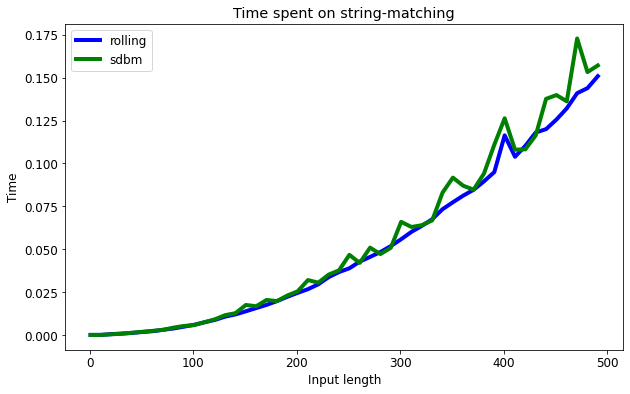

In [321]:
import time


lengths = [i for i in range(1, 501, 10)]
avg_rolling = []
avg_sdbm = []


for l in lengths:
    
    rolling = []
    sdbm = []
    
    for j in range(10):
    
        x = get_random_string(l)
        y = get_random_string(l)

        start1 = time.time()
        table1 = HashTable(x, y, 10)
        table1.build_table()
        table1.make_comparison()
        end1 = time.time()
        rolling.append(end1-start1)

        start2 = time.time()
        table2 = HashTable2(x, y, 10)
        table2.build_table_sdbm()
        table2.make_comparison_sdbm()
        end2 = time.time()
        sdbm.append(end2-start2)
        
    avg_rolling.append(sum(rolling)/10)
    avg_sdbm.append(sum(sdbm)/10)

plt.plot(lengths, avg_rolling, color="blue", label="rolling")
plt.plot(lengths, avg_sdbm, color="green", label="sdbm")
plt.title("Time spent on string-matching")
plt.xlabel("Input length")
plt.ylabel("Time")
plt.legend()
plt.show()